In [1]:
from utils import datasets, kl_cpd, models, metrics
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch
from torchvision import transforms

import numpy as np
import time
from sklearn import manifold

from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

# Load explosion videos

In [8]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name, compress_to = 48).get_dataset_()

Equal sampling is impossible, do random sampling.


# Collect training dataset

In [9]:
data_train = []
y_train = []
for (x, y) in train_dataset:
    data_train.append(x)
    y_train.append(y)
data_train_s = torch.stack(data_train)
y_train = np.stack(y_train)
y_train = y_train.reshape(-1)
data_train = torch.transpose(data_train_s, 1, 2)
data_train = data_train.reshape(data_train.shape[0] * data_train.shape[1], -1)
assert data_train.shape[0] == y_train.shape[0]

# Plot some frames from the videos

Label =  1


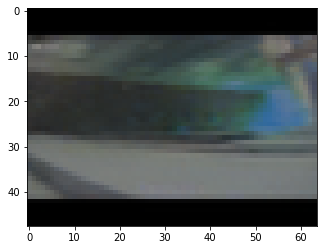

In [13]:
data_train_img = data_train.reshape(-1, x.shape[0], x.shape[2], x.shape[3])


outputIoStream = BytesIO()
i = 380

image_ = transforms.ToPILImage()(data_train_img[i, :, :, :])
print("Label = ", y_train[i])
plt.imshow(image_)

# Use manifold learning compression to 2d/3d to see if frames with explosions are easily separable

In [27]:
n_comps = [2, 3]
methods = [manifold.Isomap(), manifold.SpectralEmbedding()]
names = ["ISOMAP", "SpectralEmbedding"]
X_transformeds = {}
for n_components in n_comps:
    for i, m in enumerate(methods):
        embedding = m
        embedding.n_components = n_components
        X_transformeds[(n_components, names[i])] = embedding.fit_transform(data_train)

In [31]:
X_transformeds.keys()

dict_keys([(2, 'ISOMAP'), (2, 'SpectralEmbedding'), (3, 'ISOMAP'), (3, 'SpectralEmbedding')])

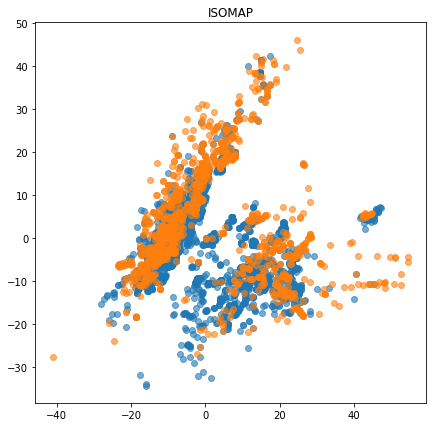

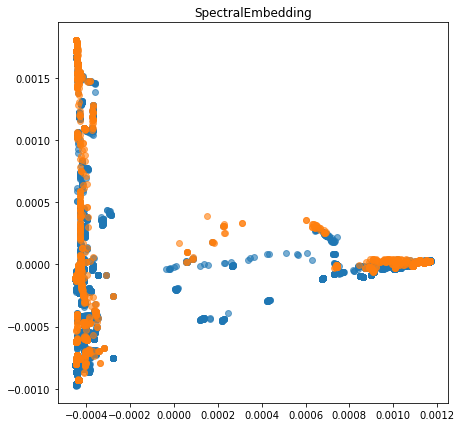

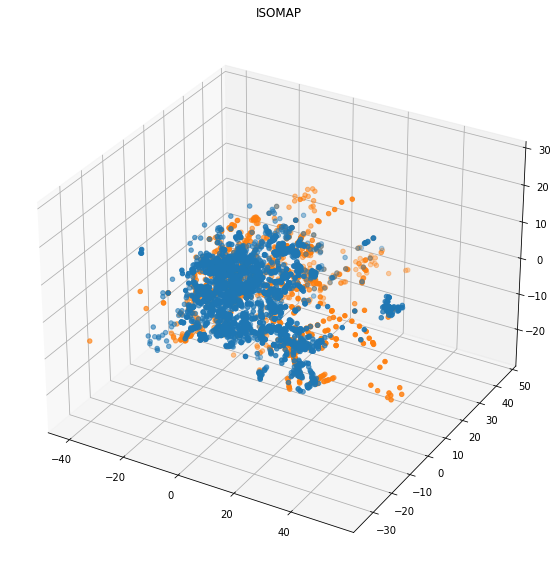

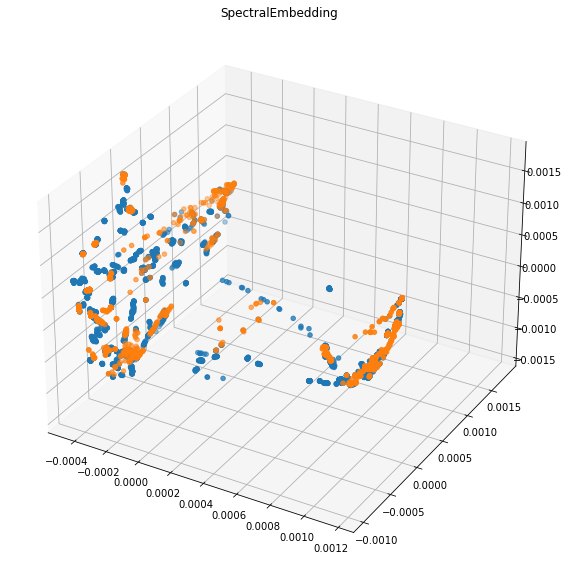

In [40]:
cdict = {0: 'C0', 1: 'C1'}
for key in X_transformeds.keys():
    n_components = key[0]
    name = key[1]
    if n_components == 3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        X_transformed = X_transformeds[(n_components, name)]
        plt.title(name)
        for g in np.unique(y_train):
            idxs = np.where(y_train == g)
            xs = X_transformed[idxs, 0]
            ys = X_transformed[idxs, 1]
            zs = X_transformed[idxs, 2]
            ax.scatter(xs, ys, zs, color=cdict[g])
    if n_components == 2:
        fig = plt.figure(figsize=(7, 7))
        plt.title(name)
        X_transformed = X_transformeds[(n_components, name)]
        for g in np.unique(y_train):
            idxs = np.where(y_train == g)
            plt.scatter(X_transformed[idxs,0], X_transformed[idxs, 1], color=cdict[g], alpha=0.6)

# Not very separable lmao